# **Machine Learning Model for Stroke Prediction using `caret`**

## Stroke Prediction Dataset: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

**Target: ‘stroke’**

### Install Libraries

In [66]:
install.packages("patchwork")
install.packages("caret")
install.packages("randomForest")
install.packages("MLmetrics")
install.packages("themis")
install.packages("ROCR")
install.packages("caretEnsemble")
install.packages("glmnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Import Libraries

In [67]:
library(tidyverse)
library(repr)
library(patchwork)
library(caret)
library(MLmetrics)
library(themis)
library(ROSE)
library(ROCR)
library(caretEnsemble)
library(glmnet)

### Explore Data

In [68]:
# import data
df <- read_csv('Stroke_Prediction.csv')
head(df)

Rows: 5110 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): gender, ever_married, work_type, Residence_type, bmi, smoking_status
dbl (6): id, age, hypertension, heart_disease, avg_glucose_level, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
56669,Male,81,0,0,Yes,Private,Urban,186.21,29,formerly smoked,1


In [69]:
# manipulation of data for a required form

# convert the bmi variable into double
df$bmi[df$bmi == 'N/A'] <- NA     # missing values
df$bmi <- as.double(df$bmi)

# convert some variables into factors
toFactor <- character()

for (col in 1:ncol(df)) {
  if (typeof(df[[col]]) == "character") {
    toFactor <- append(toFactor, colnames(df[col]))
  }
}

for (col in toFactor) {
  df[col] <- factor(df[[col]])
}


df$stroke <- factor(df$stroke, 
                    levels = c(0, 1), 
                    labels = c("No_Stroke", "Stroke"))

df$hypertension <- factor(df$hypertension, 
                    levels = c(0, 1), 
                    labels = c("No_History", "History"))

df$heart_disease <- factor(df$heart_disease, 
                          levels = c(0, 1), 
                          labels = c("No_History", "History"))

In [70]:
# summary of dataset
summary(df)

       id           gender          age            hypertension 
 Min.   :   67   Female:2994   Min.   : 0.08   No_History:4612  
 1st Qu.:17741   Male  :2115   1st Qu.:25.00   History   : 498  
 Median :36932   Other :   1   Median :45.00                    
 Mean   :36518                 Mean   :43.23                    
 3rd Qu.:54682                 3rd Qu.:61.00                    
 Max.   :72940                 Max.   :82.00                    
                                                                
    heart_disease  ever_married         work_type    Residence_type
 No_History:4834   No :1757     children     : 687   Rural:2514    
 History   : 276   Yes:3353     Govt_job     : 657   Urban:2596    
                                Never_worked :  22                 
                                Private      :2925                 
                                Self-employed: 819                 
                                                                   
    

### Data Visulization

In [71]:
# a function to change figure sizes
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

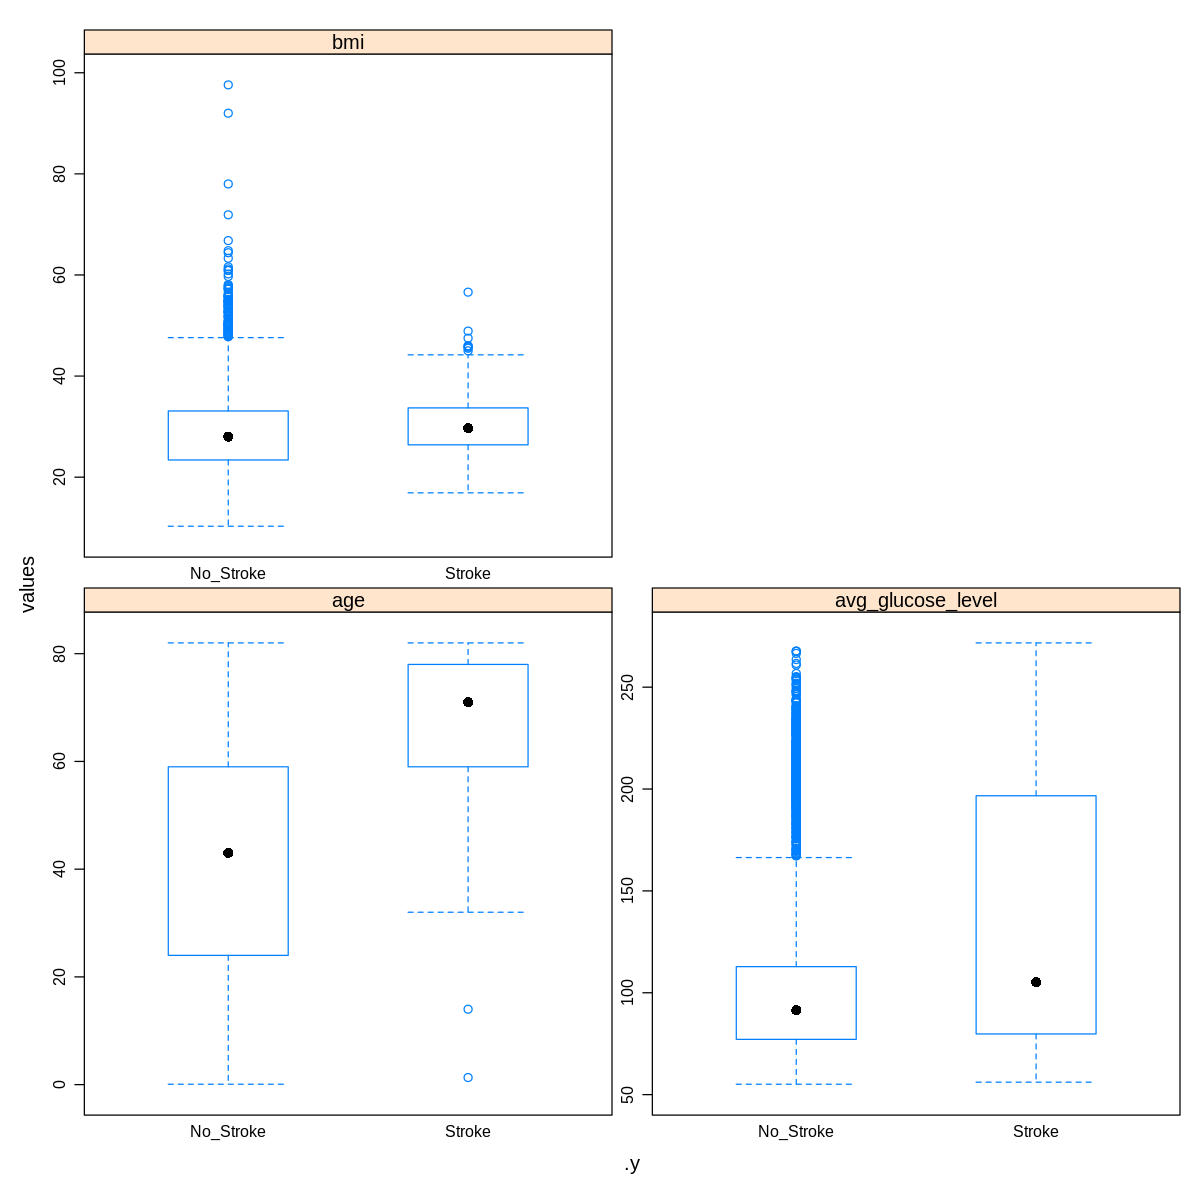

In [72]:
# Visualization of feature distribution
# feature plot using a density plot
featurePlot(x = df[,c("age", "avg_glucose_level", "bmi")],
            y = df$stroke,
            plot = "box",
            #strip = strip.custom(par.strip.text=list(cex=.7)),
            scale = list(x=list(relation="free"),
                         y=list(relation="free")),
            fig(10, 10))

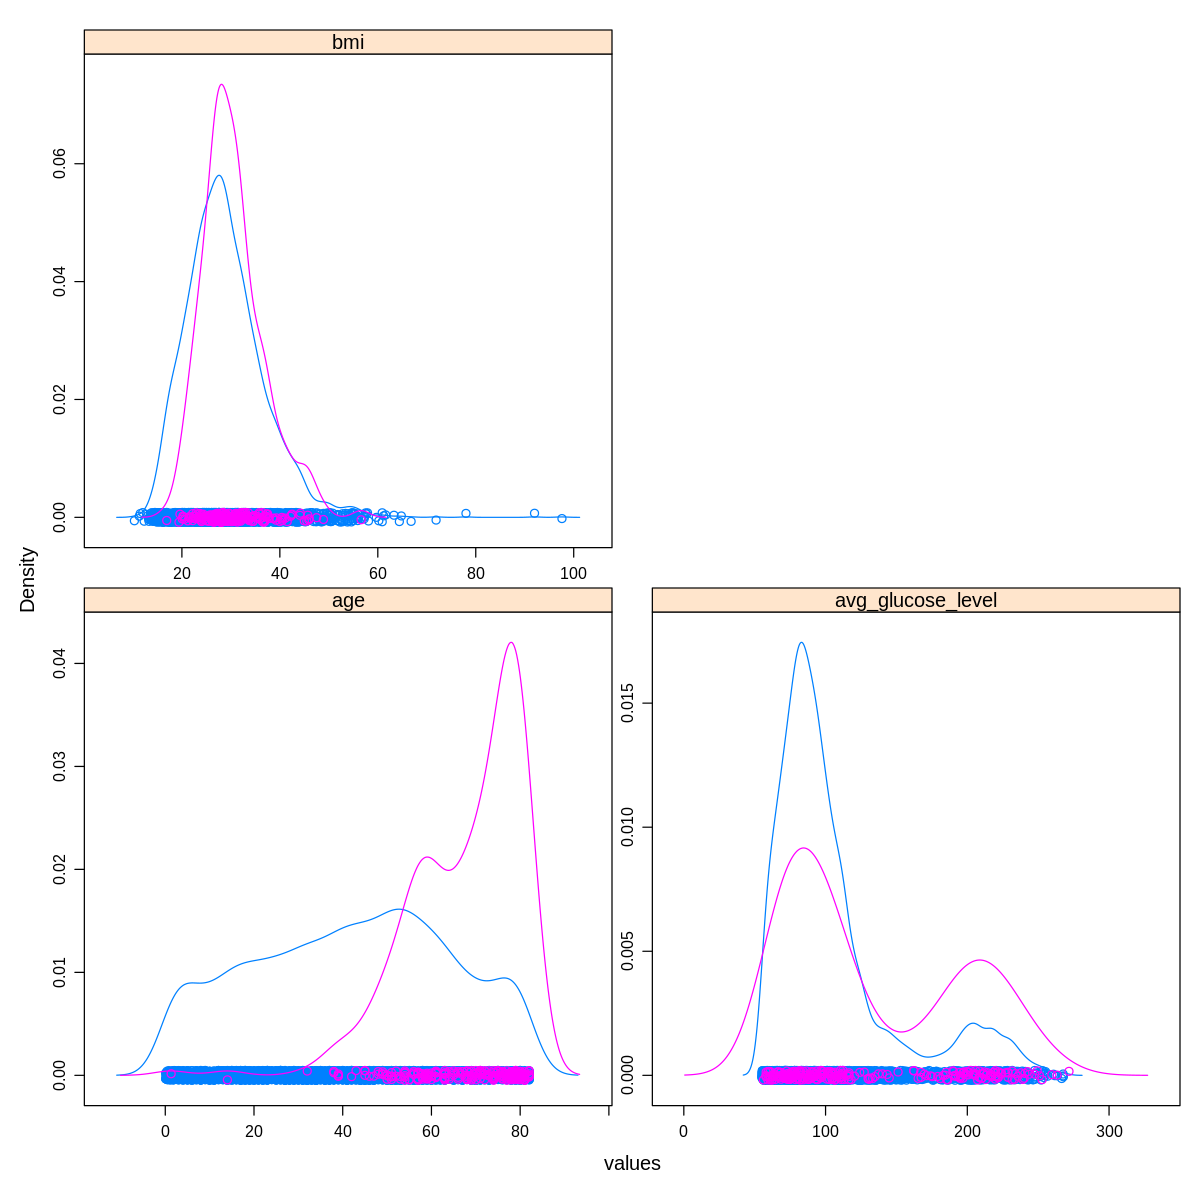

In [73]:
# feature plot using a density plot
featurePlot(x = df[,c("age", "avg_glucose_level", "bmi")],
            y = df$stroke,
            plot = "density",
            strip = strip.custom(par.strip.text=list(cex=1)),
            scale = list(x=list(relation="free"),
                         y=list(relation="free")),
            fig(10, 10))

In [74]:
# split the data into 'Stroke' and 'No-Stroke'
str_only <- df %>% 
  filter(stroke == "Stroke")

no_str_only <- df %>% 
  filter(stroke == "No_Stroke")

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


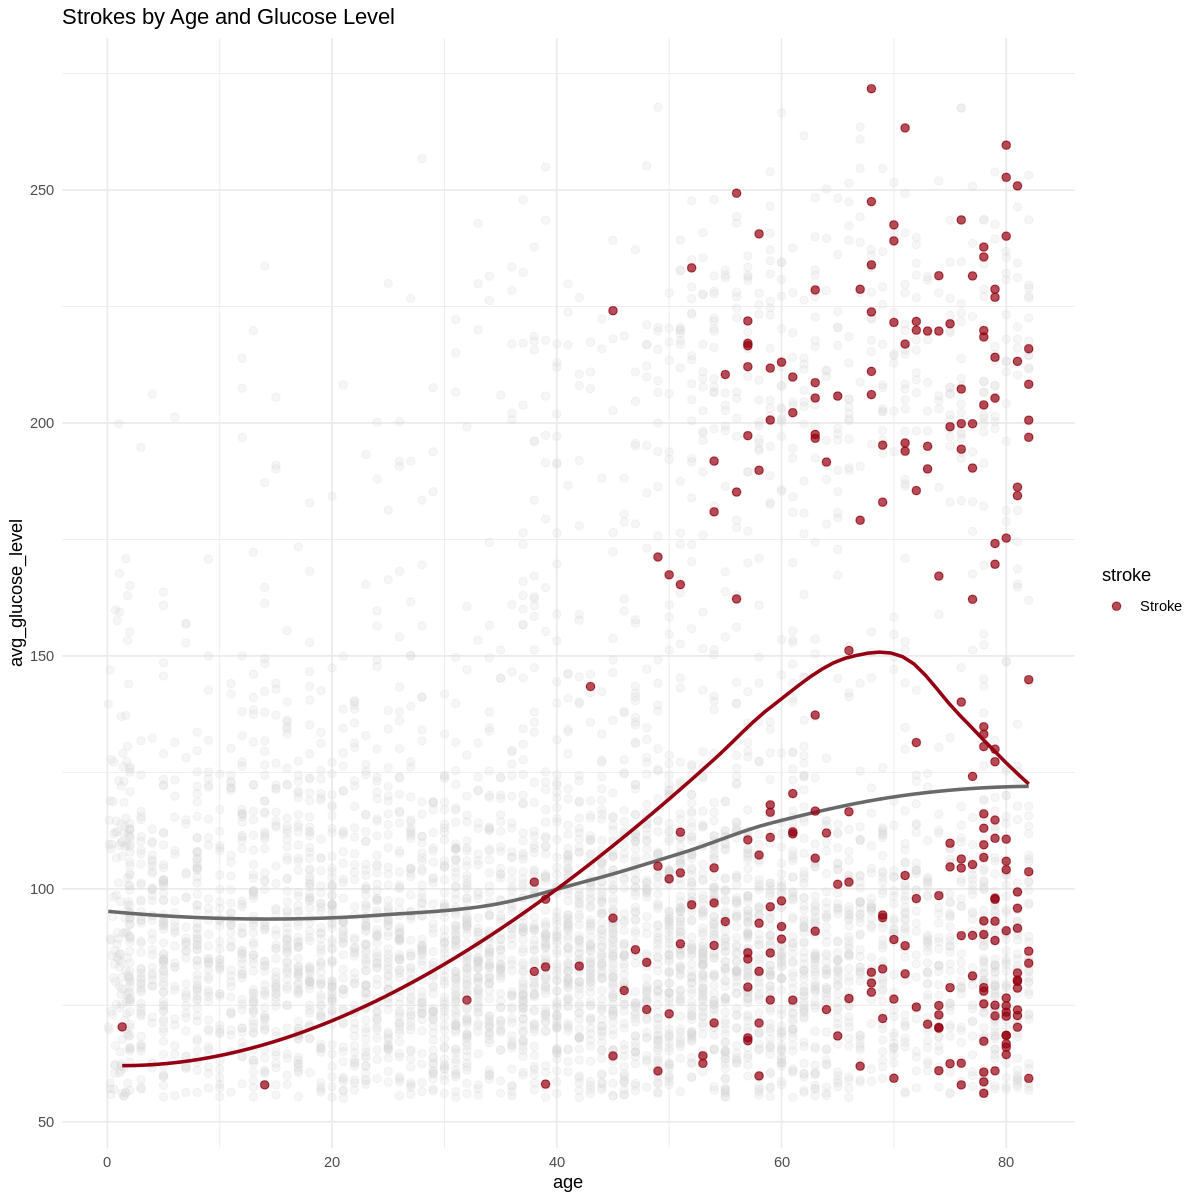

In [75]:
# glucose
ggplot(no_str_only, aes(age, avg_glucose_level)) +
  geom_point(size = 2,
             alpha = 0.2,
             color = "lightgrey") +
  geom_smooth(method = "loess",
              se = FALSE,
              color = "dimgrey") +
  geom_point(data = str_only, 
             aes(fill = stroke),
             size = 2,
             alpha = 0.7,
             color="#940011") +
  geom_smooth(data = str_only,
              method = "loess",
              se = FALSE,
              color = "#940011") +
  theme_minimal() +
  labs(title = "Strokes by Age and Glucose Level")

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 161 rows containing non-finite values (`stat_smooth()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 40 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 161 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 40 rows containing missing values (`geom_point()`).”


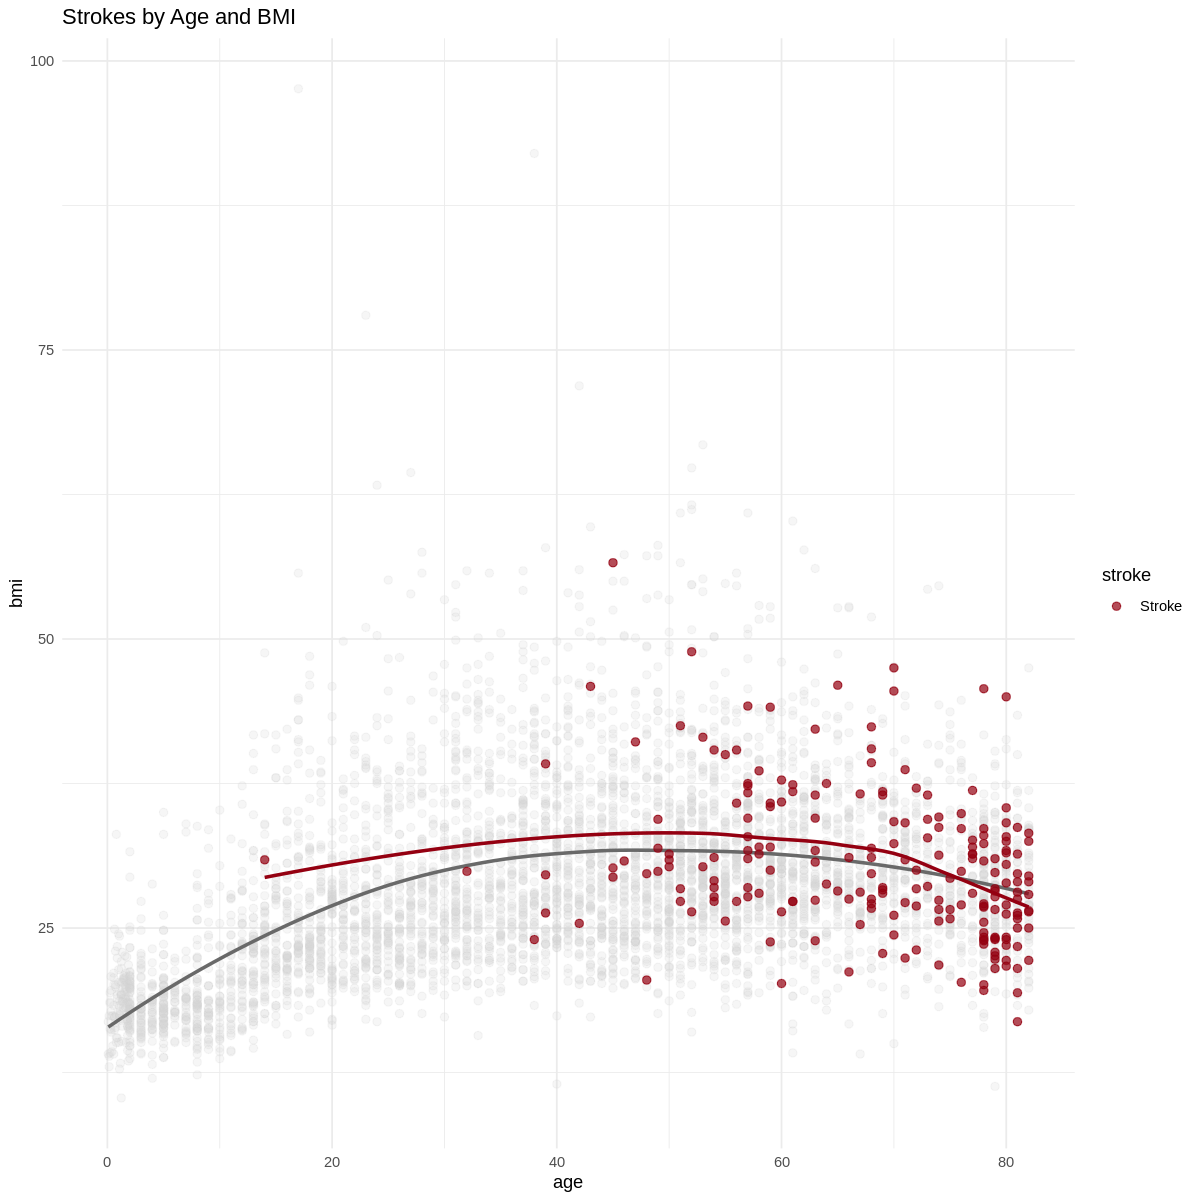

In [76]:
# bmi
ggplot(no_str_only, aes(age, bmi)) +
  geom_point(size = 2,
             alpha = 0.2,
             color = "lightgrey") +
  geom_smooth(method = "loess",
              se = FALSE,
              color = "dimgrey") +
  geom_point(data = str_only, 
             aes(fill = stroke),
             size = 2,
             alpha = 0.7,
             color="#940011") +
  geom_smooth(data = str_only,
              method = "loess",
              se = FALSE,
              color = "#940011") +
  theme_minimal() +
  labs(title = "Strokes by Age and BMI")

In [ ]:
# General Overview
# gender
p_gender <- df %>% 
  filter(gender != "Other") %>% 
  group_by(stroke, gender) %>% 
  summarise(n = n()) %>% 
  mutate(prop = n/sum(n)) %>% 
  ggplot(aes(stroke, prop, fill = stroke)) + 
    geom_col(position = "dodge") +
    facet_wrap(~ gender) +
    scale_fill_manual(values = c("#fcc7c8", "#940011")) +
    theme_minimal() +
    labs(title = "Gender")

# hypertension
p_hypertension <- df %>% 
  group_by(stroke, hypertension) %>% 
  summarise(n = n()) %>% 
  mutate(prop = n/sum(n)) %>% 
  ggplot(aes(stroke, prop, fill = stroke)) +
    geom_col(position = "dodge") +
    facet_wrap(~ hypertension) + 
    scale_fill_manual(values = c("#fcc7c8", "#940011")) +
    theme_minimal() +
    labs(title = "Hypertension",
         subtitle = "0: No History / 1: History")

# heart_disease
p_heart <- df %>% 
  group_by(stroke, heart_disease) %>% 
  summarise(n = n()) %>% 
  mutate(prop = n/sum(n)) %>% 
  ggplot(aes(stroke, prop, fill = stroke)) +
    geom_col(position = "dodge") +
    facet_wrap(~ heart_disease) + 
    scale_fill_manual(values = c("#fcc7c8", "#940011")) +
    theme_minimal() +
    labs(title = "Heart Disease",
         subtitle = "0: No History / 1: History")

# ever_married
p_married <- df %>% 
  group_by(stroke, ever_married) %>% 
  summarise(n = n()) %>% 
  mutate(prop = n/sum(n)) %>% 
  ggplot(aes(stroke, prop, fill = stroke)) +
    geom_col(position = "dodge") +
    facet_wrap(~ ever_married) + 
    scale_fill_manual(values = c("#fcc7c8", "#940011")) +
    theme_minimal() +
    labs(title = "Ever-Married")

# work_type
p_work <- df %>% 
  group_by(stroke, work_type) %>% 
  summarise(n = n()) %>% 
  mutate(prop = n/sum(n)) %>% 
  ggplot(aes(stroke, prop, fill = stroke)) +
    geom_col(position = "dodge") +
    facet_wrap(~ work_type, ncol = 5) + 
    scale_fill_manual(values = c("#fcc7c8", "#940011")) +
    theme_minimal() +
    labs(title = "Work Type")

# Residence_type
p_residence <- df %>% 
  group_by(stroke, Residence_type) %>% 
  summarise(n = n()) %>% 
  mutate(prop = n/sum(n)) %>% 
  ggplot(aes(stroke, prop, fill = stroke)) +
    geom_col(position = "dodge") +
    facet_wrap(~ Residence_type) + 
    scale_fill_manual(values = c("#fcc7c8", "#940011")) +
    theme_minimal() +
    labs(title = "Residence Type")

# smoking_status
p_smoke <- df %>% 
  group_by(stroke, smoking_status) %>% 
  summarise(n = n()) %>% 
  mutate(prop = n/sum(n)) %>% 
  ggplot(aes(stroke, prop, fill = stroke)) +
    geom_col(position = "dodge") +
    facet_wrap(~ smoking_status, ncol = 4) + 
    scale_fill_manual(values = c("#fcc7c8", "#940011")) +
    theme_minimal() +
    labs(title = "Smoking Status")

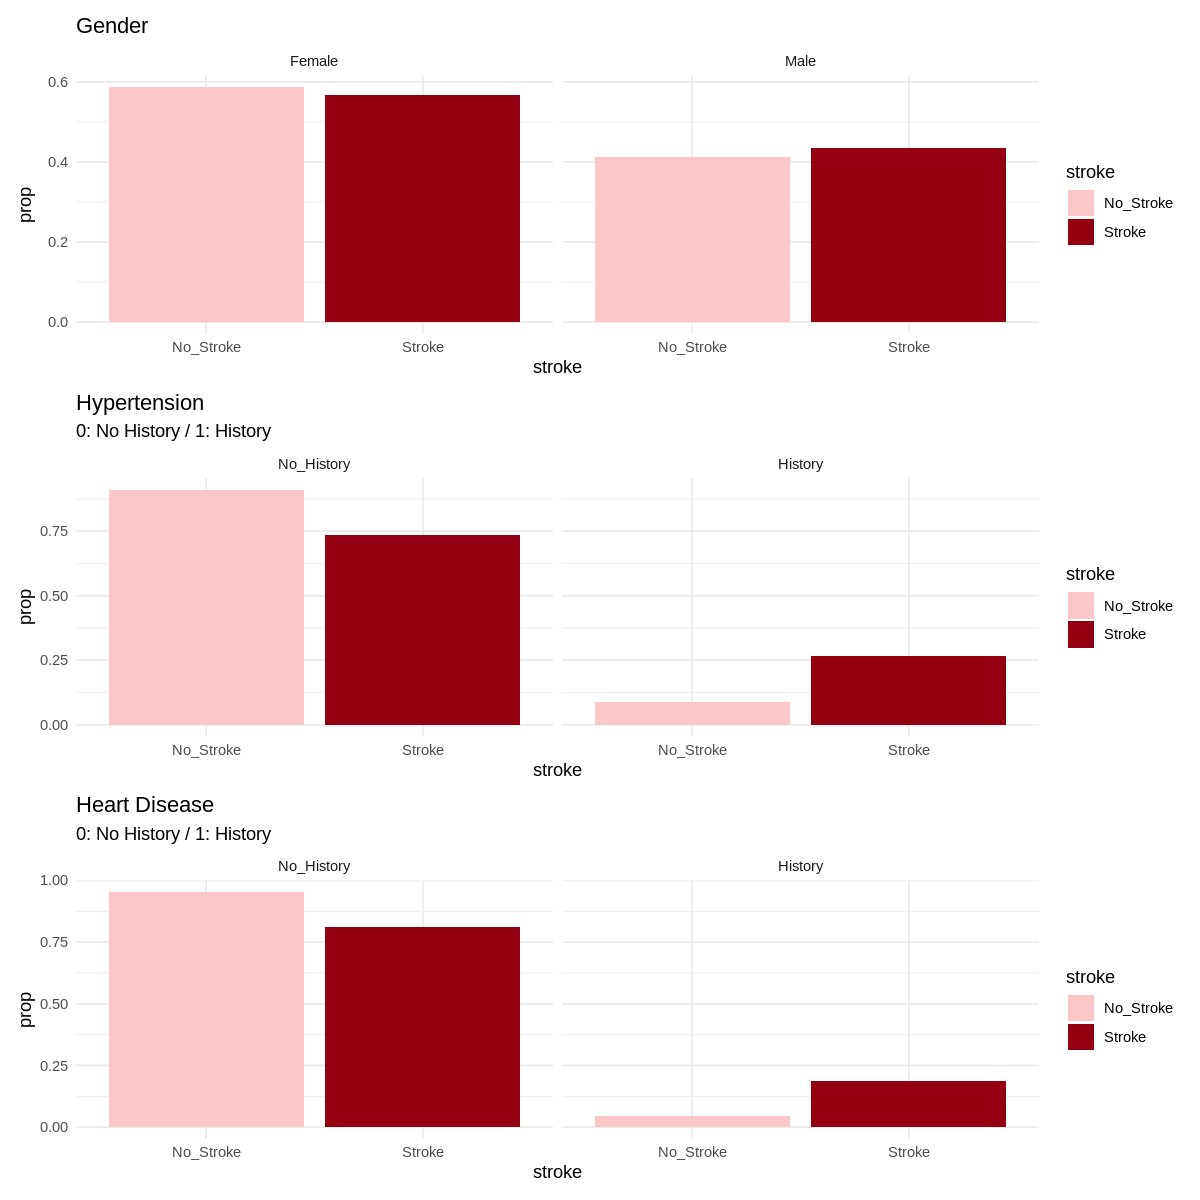

In [78]:
p_gender / p_hypertension / p_heart

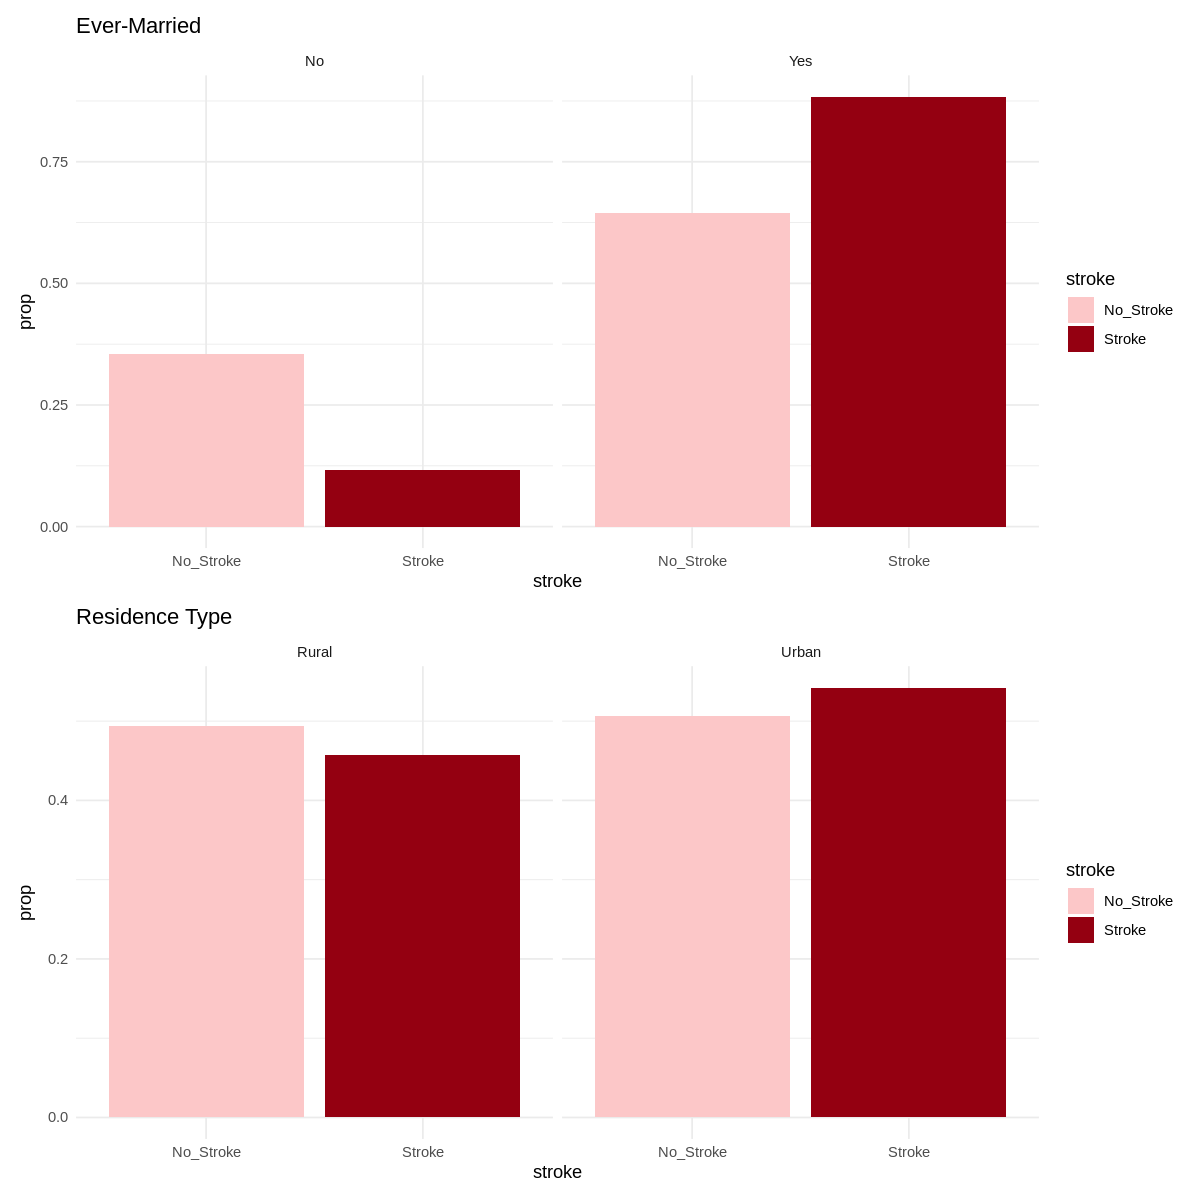

In [79]:
p_married / p_residence

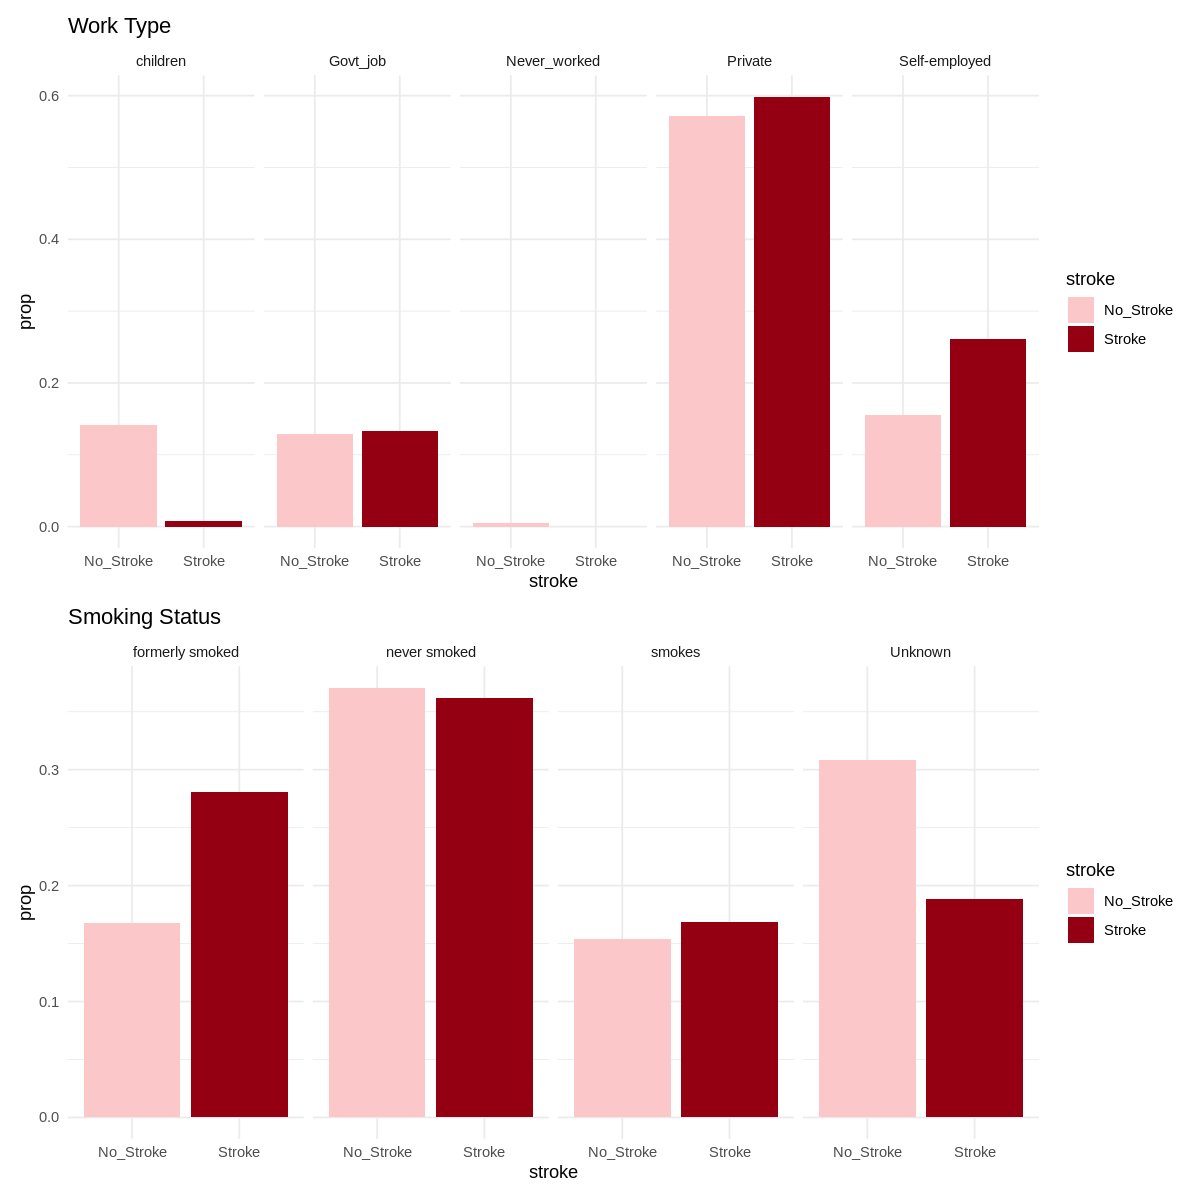

In [80]:
p_work / p_smoke

### Split Data

In [81]:
# split data
set.seed(17)
trainIndex <- createDataPartition(df$stroke, p = 0.8, list = FALSE)
train_data <- df[trainIndex, ]
test_data <- df[-trainIndex, ]

# summary of training set
summary(train_data)

       id           gender          age            hypertension 
 Min.   :   67   Female:2424   Min.   : 0.08   No_History:3692  
 1st Qu.:17608   Male  :1664   1st Qu.:25.00   History   : 397  
 Median :36518   Other :   1   Median :45.00                    
 Mean   :36252                 Mean   :43.26                    
 3rd Qu.:54344                 3rd Qu.:61.00                    
 Max.   :72940                 Max.   :82.00                    
                                                                
    heart_disease  ever_married         work_type    Residence_type
 No_History:3872   No :1404     children     : 541   Rural:2012    
 History   : 217   Yes:2685     Govt_job     : 538   Urban:2077    
                                Never_worked :  19                 
                                Private      :2327                 
                                Self-employed: 664                 
                                                                   
    

In [82]:
# the bagging imputation method for filling in missing data
set.seed(17)
bagMissing <- preProcess(train_data[-1], method = "bagImpute")      #col1 = id
train_data_imputed <- predict(bagMissing, newdata =  train_data)

cat("\nTotal missing values in the dataset:", sum(is.na(train_data_imputed)))
cat("\nThe proportion of complete rows:", mean(complete.cases(train_data_imputed)))


Total missing values in the dataset: 0
The proportion of complete rows: 1

In [ ]:
# transform to a one-hot encoding data structure
# the output will be a matrix of the predictors, which omits the response variable
dummyModel <- dummyVars(stroke ~ ., 
                        data = train_data_imputed, 
                        fullRank = TRUE)
train_data_dummy <- predict(dummyModel, newdata = train_data_imputed)

In [84]:
# normalize predictors -> transforms variables to be between 0 and 1 
# transform the variables into a 0-1 scale -> method = "range"
rangeModel <- preProcess(train_data_dummy, method = "range")
train_data_range <- predict(rangeModel, newdata = train_data_dummy)

In [85]:
# turn a predictor matrix into a data frame
train_data_range <- data.frame(train_data_range)

# add response variable back to training set
train_data <- cbind(train_data$stroke, train_data_range)
names(train_data)[1] <- "stroke"

In [ ]:
# apply the same transformations to the test set
test_data_imputed <- predict(bagMissing, newdata = test_data)
test_data_dummy <- predict(dummyModel, newdata = test_data_imputed)
test_data_range <- predict(rangeModel, newdata = test_data_dummy)
test_data_range <- data.frame(test_data_range)
test_data <- cbind(test_data$stroke, test_data_range)

names(test_data) <- names(train_data)       # make sure the names are the same


No_Stroke    Stroke 
     3889       200 


An imbalanced dataset
No-Stroke Proportion:  0.951
Stroke Proportion:     0.049 



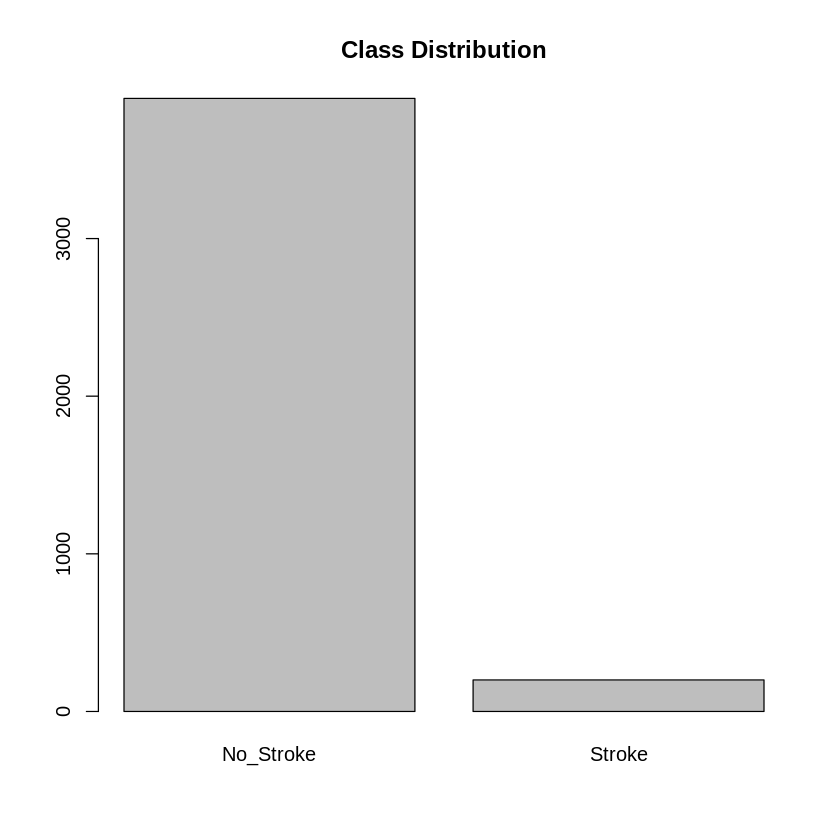

In [88]:
#### imbalanced dataset
table(train_data$stroke)
cat("\nAn imbalanced dataset")
cat("\nNo-Stroke Proportion: ", round(table(train_data$stroke)[1]/sum(table(train_data$stroke)), 3))
cat("\nStroke Proportion:    ", round(table(train_data$stroke)[2]/sum(table(train_data$stroke)), 3), "\n")
cat("\n")
barplot(table(train_data$stroke), main = "Class Distribution")
fig(7,7)

### A Random Forest model with minimum configuration

In [89]:
# a random forest model with minimum configuration
set.seed(17)
rf_model <- train(stroke ~. -id,
                   data = train_data,
                   method = "rf")

rf_model

Random Forest 

4089 samples
  17 predictor
   2 classes: 'No_Stroke', 'Stroke' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 4089, 4089, 4089, 4089, 4089, 4089, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa     
   2    0.9528241  0.00000000
   9    0.9484567  0.03278568
  16    0.9461462  0.04719064

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

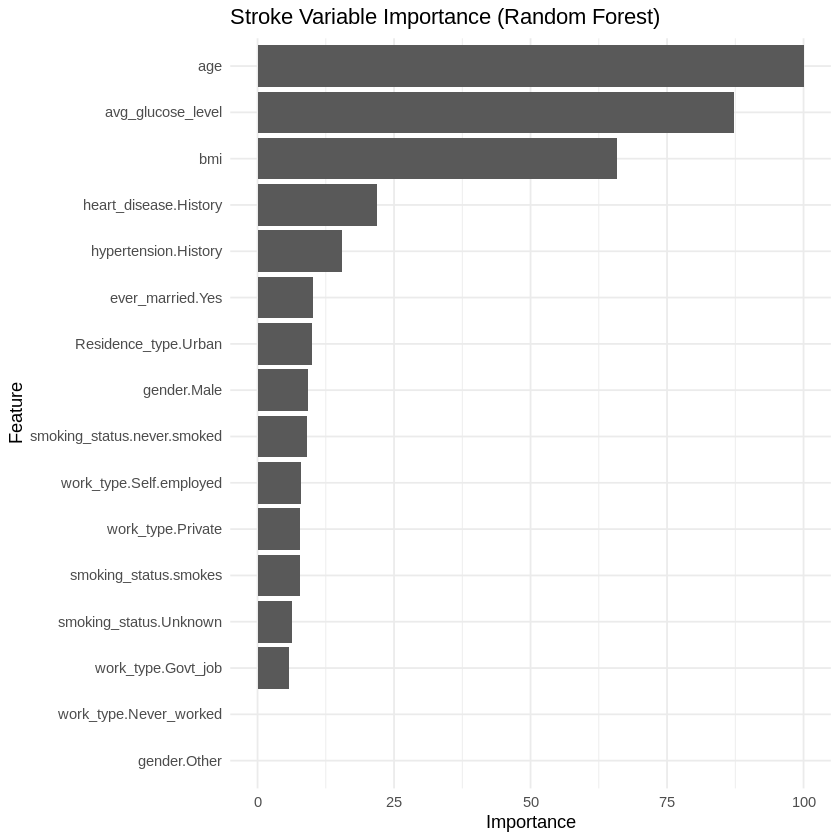

In [90]:
# variable importance plot from random forest
varimp_rf <- varImp(rf_model)
ggplot(varimp_rf) +
  theme_minimal() +
  labs(title = "Stroke Variable Importance (Random Forest)")

In [91]:
# model evaluation
# predicted values
p_rf <- predict(rf_model, newdata = test_data)

# confusion matrix comparing comparing predicted values to actual values
confusionMatrix(data = p_rf,
                reference = test_data$stroke,
                positive = "Stroke",
                mode = "everything")

Confusion Matrix and Statistics

           Reference
Prediction  No_Stroke Stroke
  No_Stroke       972     49
  Stroke            0      0
                                         
               Accuracy : 0.952          
                 95% CI : (0.937, 0.9643)
    No Information Rate : 0.952          
    P-Value [Acc > NIR] : 0.5379         
                                         
                  Kappa : 0              
                                         
 Mcnemar's Test P-Value : 7.025e-12      
                                         
            Sensitivity : 0.00000        
            Specificity : 1.00000        
         Pos Pred Value :     NaN        
         Neg Pred Value : 0.95201        
              Precision :      NA        
                 Recall : 0.00000        
                     F1 :      NA        
             Prevalence : 0.04799        
         Detection Rate : 0.00000        
   Detection Prevalence : 0.00000        
      Balanced Accu

### The hyperparameter tuning

In [92]:
# look up hyperparameters of Random Forest
modelLookup("rf")     # hyperparameters to be tuned

,model,parameter,label,forReg,forClass,probModel
,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>
1,rf,mtry,#Randomly Selected Predictors,TRUE,TRUE,TRUE


In [93]:
# define a training control
# prSummary -> optimize across the tradeoff between Recall and Precision (Sensitivity and Positive Predictive Value)
prCtrl <- trainControl(method = "cv",
                     number = 5,                    # 5-fold cross-validation
                     savePredictions = "final",
                     classProbs = TRUE,
                     summaryFunction = prSummary)

In [94]:
# the training control with a pre-specified tuning length
set.seed(17)
rfTL_model <- train(stroke ~. -id,
                    data = train_data,
                    method = "rf",
                    metric = "AUC",
                    trControl = prCtrl,
                    tuneLength = 7)         # 7 numbers of mtry hyperparameter values

rfTL_model

Random Forest 

4089 samples
  17 predictor
   2 classes: 'No_Stroke', 'Stroke' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 3271, 3271, 3271, 3272, 3271 
Resampling results across tuning parameters:

  mtry  AUC        Precision  Recall     F        
   2    0.6110242  0.9510883  1.0000000  0.9749311
   4    0.7158679  0.9512972  0.9994859  0.9747962
   6    0.6892851  0.9512493  0.9984573  0.9742810
   9    0.6297464  0.9516562  0.9971716  0.9738810
  11    0.5977647  0.9516570  0.9971716  0.9738826
  13    0.5778713  0.9516332  0.9966571  0.9736247
  16    0.5511221  0.9516094  0.9961430  0.9733668

AUC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 4.

In [95]:
# model evaluation
# predicted values
p_rfTL <- predict(rfTL_model, newdata = test_data)

# confusion matrix comparing comparing predicted values to actual values
cm_original <- confusionMatrix(data = p_rfTL,
                reference = test_data$stroke,
                positive = "Stroke",
                mode = "everything")
cm_original

Confusion Matrix and Statistics

           Reference
Prediction  No_Stroke Stroke
  No_Stroke       970     49
  Stroke            2      0
                                          
               Accuracy : 0.95            
                 95% CI : (0.9348, 0.9626)
    No Information Rate : 0.952           
    P-Value [Acc > NIR] : 0.6499          
                                          
                  Kappa : -0.0038         
                                          
 Mcnemar's Test P-Value : 1.185e-10       
                                          
            Sensitivity : 0.000000        
            Specificity : 0.997942        
         Pos Pred Value : 0.000000        
         Neg Pred Value : 0.951914        
              Precision : 0.000000        
                 Recall : 0.000000        
                     F1 :      NaN        
             Prevalence : 0.047992        
         Detection Rate : 0.000000        
   Detection Prevalence : 0.001959        

### Using non-stardard sampling methods for class imbalance

In [96]:
# down-sampling
downPrCtrl <- trainControl(method = "cv",
                           number = 5,
                           savePredictions = "final",
                           classProbs = TRUE,
                           summaryFunction = prSummary,
                           sampling = "down")               # down-sampling

set.seed(17)
rfDown_model <- train(stroke ~. -id,
                      data = train_data,
                      method = "rf",
                      metric = "AUC",
                      trControl = downPrCtrl,
                      tuneLength = 7)

cat("The down-sampled training case\n\n")

p_rfDown <- predict(rfDown_model, newdata = test_data)
cm_down <- confusionMatrix(data = p_rfDown,
                reference = test_data$stroke,
                positive = "Stroke",
                mode = "everything")
cm_down

The down-sampled training case



Confusion Matrix and Statistics

           Reference
Prediction  No_Stroke Stroke
  No_Stroke       657     11
  Stroke          315     38
                                          
               Accuracy : 0.6807          
                 95% CI : (0.6511, 0.7092)
    No Information Rate : 0.952           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1144          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.77551         
            Specificity : 0.67593         
         Pos Pred Value : 0.10765         
         Neg Pred Value : 0.98353         
              Precision : 0.10765         
                 Recall : 0.77551         
                     F1 : 0.18905         
             Prevalence : 0.04799         
         Detection Rate : 0.03722         
   Detection Prevalence : 0.34574         

In [97]:
# up-sampling
upPrCtrl <- trainControl(method = "cv",
                         number = 5,
                         savePredictions = "final",
                         classProbs = TRUE,
                         summaryFunction = prSummary,
                         sampling = "up")               # up-sampling

set.seed(17)
rfUp_model <- train(stroke ~. -id,
                      data = train_data,
                      method = "rf",
                      metric = "AUC",
                      trControl = upPrCtrl,
                      tuneLength = 7)

cat("The up-sampled training case\n\n")

p_rfUp <- predict(rfUp_model, newdata = test_data)
cm_up <- confusionMatrix(data = p_rfUp,
                reference = test_data$stroke,
                positive = "Stroke",
                mode = "everything")
cm_up

The up-sampled training case



Confusion Matrix and Statistics

           Reference
Prediction  No_Stroke Stroke
  No_Stroke       743     16
  Stroke          229     33
                                          
               Accuracy : 0.76            
                 95% CI : (0.7326, 0.7859)
    No Information Rate : 0.952           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1429          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.67347         
            Specificity : 0.76440         
         Pos Pred Value : 0.12595         
         Neg Pred Value : 0.97892         
              Precision : 0.12595         
                 Recall : 0.67347         
                     F1 : 0.21222         
             Prevalence : 0.04799         
         Detection Rate : 0.03232         
   Detection Prevalence : 0.25661         

In [98]:
# SMOTE: Synthetic Minority Over-sampling TEchnique
smotePrCtrl <- trainControl(method = "cv",
                            number = 5,
                            savePredictions = "final",
                            classProbs = TRUE,
                            summaryFunction = prSummary,
                            sampling = "smote")             # SMOTE

set.seed(17)
rfSMOTE_model <- train(stroke ~. -id,
                    data = train_data,
                    method = "rf",
                    metric = "AUC",
                    trControl = smotePrCtrl,
                    tuneLength = 7)

cat("SMOTE method\n\n")

p_rfSMOTE <- predict(rfSMOTE_model, newdata = test_data)
cm_smote <- confusionMatrix(data = p_rfSMOTE,
                reference = test_data$stroke,
                positive = "Stroke",
                mode = "everything")
cm_smote

SMOTE method



Confusion Matrix and Statistics

           Reference
Prediction  No_Stroke Stroke
  No_Stroke       795     28
  Stroke          177     21
                                          
               Accuracy : 0.7992          
                 95% CI : (0.7733, 0.8234)
    No Information Rate : 0.952           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1009          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.42857         
            Specificity : 0.81790         
         Pos Pred Value : 0.10606         
         Neg Pred Value : 0.96598         
              Precision : 0.10606         
                 Recall : 0.42857         
                     F1 : 0.17004         
             Prevalence : 0.04799         
         Detection Rate : 0.02057         
   Detection Prevalence : 0.19393         

In [99]:
# ROSE: Random Over-Sampling Examples
rosePrCtrl <- trainControl(method = "cv",
                           number = 5,
                           savePredictions = "final",
                           classProbs = TRUE,
                           summaryFunction = prSummary,
                           sampling = "rose")               # ROSE

set.seed(17)
rfROSE_model <- train(stroke ~. -id,
                       data = train_data,
                       method = "rf",
                       metric = "AUC",
                       trControl = rosePrCtrl,
                       tuneLength = 7)

cat("ROSE method\n\n")

p_rfROSE <- predict(rfROSE_model, newdata = test_data)
cm_rose <- confusionMatrix(data = p_rfROSE,
                reference = test_data$stroke,
                positive = "Stroke",
                mode = "everything")
cm_rose

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


ROSE method



Confusion Matrix and Statistics

           Reference
Prediction  No_Stroke Stroke
  No_Stroke         3      0
  Stroke          969     49
                                          
               Accuracy : 0.0509          
                 95% CI : (0.0383, 0.0663)
    No Information Rate : 0.952           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 3e-04           
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 1.000000        
            Specificity : 0.003086        
         Pos Pred Value : 0.048134        
         Neg Pred Value : 1.000000        
              Precision : 0.048134        
                 Recall : 1.000000        
                     F1 : 0.091846        
             Prevalence : 0.047992        
         Detection Rate : 0.047992        
   Detection Prevalence : 0.997062        

### Comparison of Sampling Methods

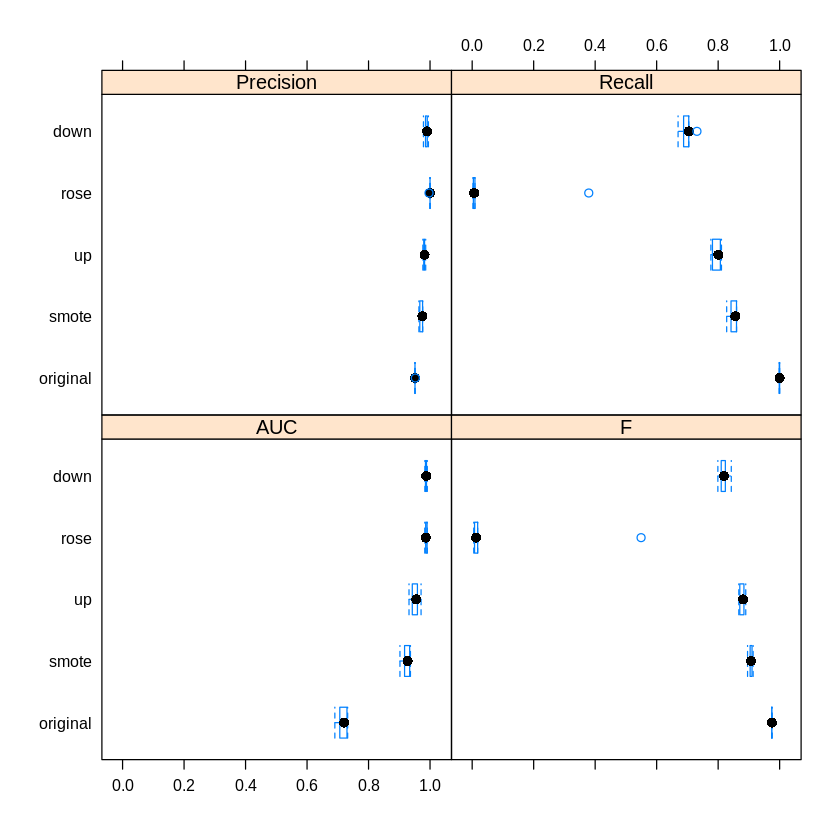

In [100]:
# all models
models <- list(original = rfTL_model,
               down = rfDown_model,
               up = rfUp_model,
               smote = rfSMOTE_model,
               rose = rfROSE_model)

resampling <- resamples(models)
#summary(resampling)
bwplot(resampling)

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


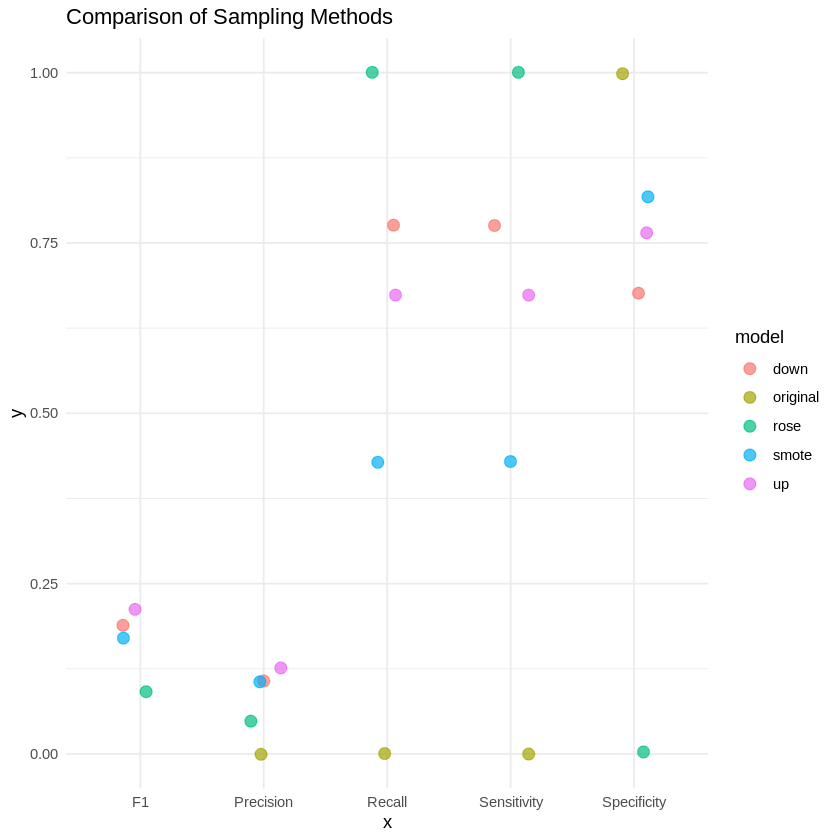

In [101]:
# comparison of sampling methods
comparison <- data.frame(model = names(models),
                         Sensitivity = rep(NA, length(models)),
                         Specificity = rep(NA, length(models)),
                         Precision = rep(NA, length(models)),
                         Recall = rep(NA, length(models)),
                         F1 = rep(NA, length(models)))


# get() -> Return the Value of a Named Object
for (name in names(models)) {
  cm <- get(paste0("cm_", name))
  
  comparison[comparison$model == name, ] <- filter(comparison, 
                                                   model == name) %>% 
    mutate(Sensitivity = cm$byClass["Sensitivity"],
           Specificity = cm$byClass["Specificity"],
           Precision = cm$byClass["Precision"],
           Recall = cm$byClass["Recall"],
           F1 = cm$byClass["F1"])
}

comparison %>% 
  pivot_longer(-model,
               names_to = "x",
               values_to = "y") %>% 
  ggplot(aes(x, y, color = model)) +
    geom_jitter(size = 3,
               alpha = 0.7,
               width = 0.15) +
    theme_minimal() +
    labs(title = "Comparison of Sampling Methods")

### Altering boundaries for classifier thresholds

In [103]:
# predictions from different sampling methods
p_rfTL_probs <- predict(rfTL_model, newdata = test_data, type = "prob")
p_rfDown_probs <- predict(rfDown_model, newdata = test_data, type = "prob")
p_rfUp_probs <- predict(rfUp_model, newdata = test_data, type = "prob")
p_rfSMOTE_probs <- predict(rfSMOTE_model, newdata = test_data, type = "prob")
p_rfROSE_probs <- predict(rfROSE_model, newdata = test_data, type = "prob")

p_rfResampledModel <- list(original = p_rfTL_probs,
                           down = p_rfDown_probs,
                           up = p_rfUp_probs,
                           smote = p_rfSMOTE_probs,
                           rose = p_rfROSE_probs)

In [109]:
# create new thresholds for classification
model <- vector()
thresh <- seq(0.1, 0.9, by = 0.1)
precision <- vector()
recall <- vector()
sensitivity <- vector()
specificity <- vector()
k = 1

while (k<=length(p_rfResampledModel)) {
  for (j in p_rfResampledModel[k]) {
    
    for (i in 1:length(thresh)) {
      
      pred_class <- factor(ifelse(j$Stroke > thresh[i], 
                                  "Stroke", 
                                  "No_Stroke"),
                           levels =  c("No_Stroke", "Stroke"))
      
      cm <- confusionMatrix(pred_class, 
                            test_data$stroke, 
                            positive = "Stroke", 
                            mode = "everything")
      
      model <- append(model, names(p_rfResampledModel)[k])
      sensitivity <- append(sensitivity, cm$byClass["Sensitivity"])
      specificity <- append(specificity, cm$byClass["Specificity"])
      precision <- append(precision, cm$byClass["Precision"])
      recall <- append(recall, cm$byClass["Recall"])
    }
  
  }
  
  k <- k+1
}

dicisionThreshold <- data.frame(model = model,
                                threshold = thresh,
                                sensitivity = sensitivity,
                                specificity = specificity,
                                precision = precision,
                                recall = recall)

dicisionThreshold <- tibble(dicisionThreshold)
dicisionThreshold %>% 
  head(15)

model,threshold,sensitivity,specificity,precision,recall
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
original,0.1,0.5714286,0.8765432,0.18918919,0.5714286
original,0.2,0.1632653,0.9629630,0.18181818,0.1632653
original,0.3,0.1020408,0.9845679,0.25000000,0.1020408
original,0.4,0.0000000,0.9948560,0.00000000,0.0000000
original,0.5,0.0000000,0.9979424,0.00000000,0.0000000
original,0.6,0.0000000,0.9989712,0.00000000,0.0000000
original,0.7,0.0000000,1.0000000,NA,0.0000000
original,0.8,0.0000000,1.0000000,NA,0.0000000
original,0.9,0.0000000,1.0000000,NA,0.0000000


### Create ROC and Precision-Recall curves for all Sampling Methods

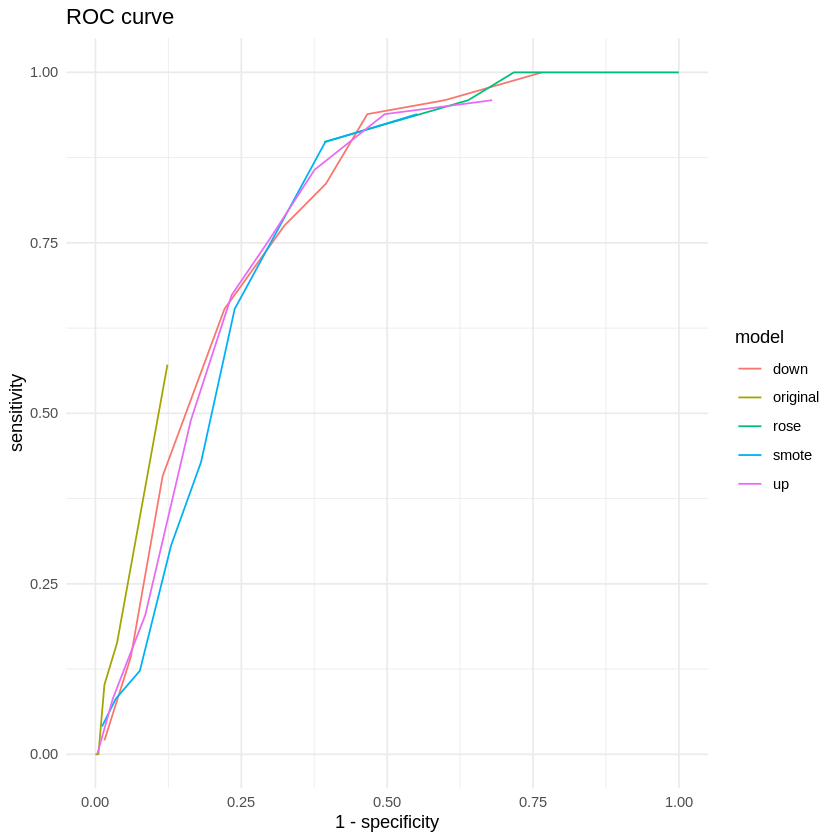

In [130]:
# create a ROC curve
dicisionThreshold %>% 
  ggplot(aes(x=1-specificity, y=sensitivity, color=model)) +
    geom_line() +
    theme_minimal() +
    labs(title = "ROC curve")

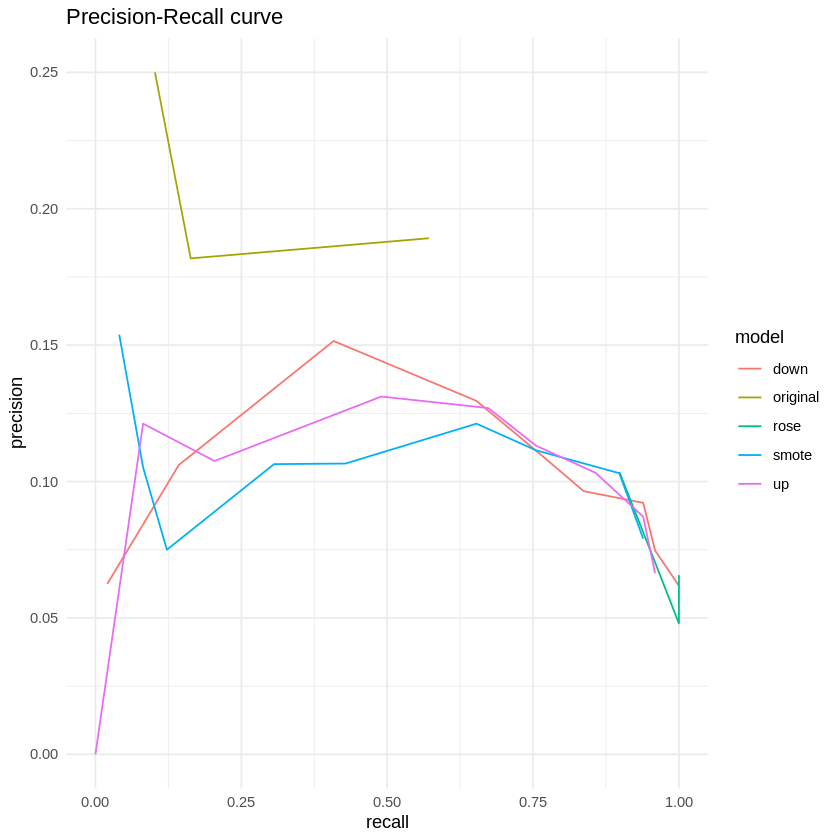

In [129]:
# create a Precision-Recall curve
dicisionThreshold %>% 
  ggplot(aes(x=recall, y=precision, color=model)) +
  geom_line() +
  theme_minimal() +
  labs(title = "Precision-Recall curve")

### Training and resampling multiple models

In [117]:
# a training control of multiple models
# index() = make sure the resampling indices are the same for all models
set.seed(17)
ensembleControl <- trainControl(method = "cv",
                                number = 5,
                                index = createFolds(train_data$stroke, k = 5),
                                savePredictions = "final",
                                classProbs = TRUE,
                                summaryFunction = prSummary,
                                sampling = "down")

In [118]:
# list of methods
# 1st approach
methodList <- c("rf", "knn", "glmnet")  

# 2nd approach -> more customized
tuneList <- list(
  rf = caretModelSpec(method = "rf", tuneLength = 7),
  knn = caretModelSpec(method = "knn", tuneLength = 7),
  glmnet = caretModelSpec(method = "glmnet", tuneLength = 7)
)

In [119]:
# train the ensemble of models
set.seed(17)
ensemble <- caretList(stroke ~. -id,
          data = train_data,
          #methodList = methodList,
          tuneList = tuneList,
          metric = "AUC",
          trControl = ensembleControl)

In [120]:
# all model performances
resampledList <- resamples(ensemble)
summary(resampledList)


Call:
summary.resamples(object = resampledList)

Models: rf, knn, glmnet 
Number of resamples: 5 

AUC 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
rf     0.9849521 0.9851023 0.9863608 0.9860743 0.9865684 0.9873882    0
knn    0.9553507 0.9679763 0.9758892 0.9716654 0.9793910 0.9797200    0
glmnet 0.9864133 0.9874024 0.9886085 0.9882474 0.9889794 0.9898331    0

F 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
rf     0.8144796 0.8243394 0.8316024 0.8292814 0.8329950 0.8429903    0
knn    0.7246201 0.7476820 0.7962085 0.7886856 0.8304244 0.8444928    0
glmnet 0.7810743 0.8185241 0.8247847 0.8230389 0.8407291 0.8500824    0

Precision 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
rf     0.9771186 0.9783268 0.9787892 0.9804178 0.9829022 0.9849521    0
knn    0.9683189 0.9691252 0.9695833 0.9715431 0.9704251 0.9802632    0
glmnet 0.9840517 0.9848411 0.9872449 0.9862640 0.9874496 0.9877328    0

Recall 
      